In [1]:
import os
os.getcwd()

'/content'

In [2]:
os.listdir(os.getcwd())

['sample_data', '.config']

In [0]:
os.mkdir('Seedling_sample')

In [109]:
os.listdir('/content/Seedling_sample')

['Train.zip', 'Train', 'model.json']

In [0]:
os.chdir('Seedling_sample')

In [5]:
os.getcwd()

'/content/Seedling_sample'

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
       print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

Saving Train.zip to Train.zip
User uploaded file "Train.zip" with length 277769593 bytes


In [8]:
import zipfile as zf
train_zip = zf.ZipFile("Train.zip")
train_zip.extractall()
!ls

Train  Train.zip


In [9]:
#see contents of train file
!ls Train

 Cleavers  'Common wheat'   Maize


In [0]:
#list of useful imports that  I will use
%matplotlib inline
import os

import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np
from glob import glob
import seaborn as sns

In [13]:
os.listdir(os.getcwd())

['Train.zip', 'Train']

In [0]:
#save the path into variable to use it easily next times.
TRAin_DATA_FOLDER= "Train"

In [0]:
images = []
classes=[]
missing=0
for class_folder_name in os.listdir(TRAin_DATA_FOLDER):
    class_folder_path = os.path.join(TRAin_DATA_FOLDER, class_folder_name)
    class_label = class_folder_name
    
    for image_path in glob(os.path.join(class_folder_path, "*.png")):
        image_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if image_bgr is None: # if the file contain any missig value ignore it
          missing += 1
          continue
        images.append(image_bgr)
        
        classes.append(class_label)

In [16]:
len(images)

729

In [0]:
def resize_images(img):

  img = np.array(img).astype(np.uint8)
  #print(img.dtype)
  res = cv2.resize(img,(256,256), interpolation = cv2.INTER_CUBIC)
  return res
#resized=[]
#for image in images:
#  ressized= resize_images(images[image])

In [0]:
#save resized images into images.
images = [resize_images(img) for img in images]

In [19]:
images[0].shape

(256, 256, 3)

In [20]:
#see number of images in each lablel
images = np.array(images)
classes = np.array(classes)
print("images shape: ", images.shape)
print("classes shape: ", classes.shape)
#for key,value in images_per_class.items():
   # print("number of {0} images is  -> {1}".format(key, len(value)))
  
for label in set(classes):

  print("number of {} images is  -> {}".format(
        label, 
        len(images[classes == label])))

images shape:  (729, 256, 256, 3)
classes shape:  (729,)
number of Common wheat images is  -> 221
number of Cleavers images is  -> 287
number of Maize images is  -> 221


Text(0.5,0.98,'Categorical Plotting')

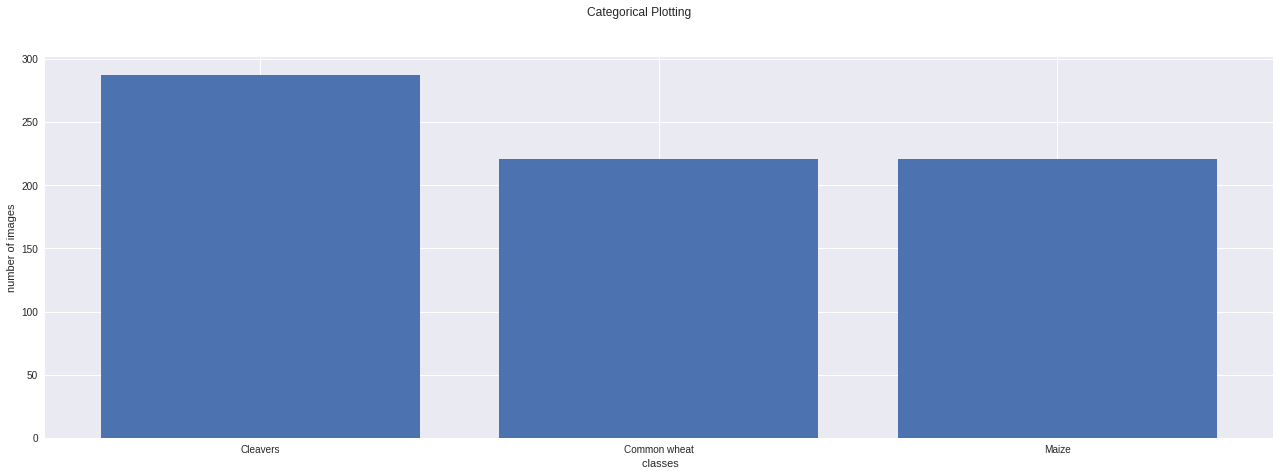

In [21]:
values =[]
labels=[]
for label in set(classes):
  values.append(len(images[classes == label]))
  labels.append(label)

fig, ax = plt.subplots(figsize=(22,7))
ax.bar(labels, values)
ax.set_xlabel(" classes")
ax.set_ylabel("number of images")
#axs[1].scatter(label, )
  #axs[2].plot(names, values)
fig.suptitle('Categorical Plotting')

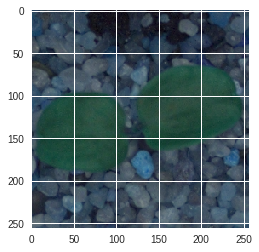

In [22]:
plt.imshow(images[50])

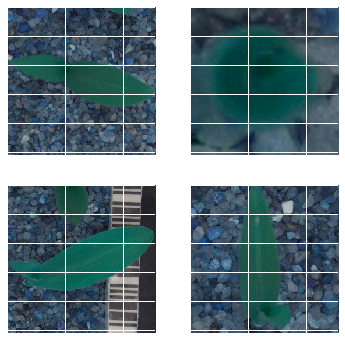

In [27]:
def plot_for_class(label):
    nb_rows = 2
    nb_cols = 2
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(6, 6))
    class_images =images[classes== label]
    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].xaxis.set_ticklabels([])
            axs[i, j].yaxis.set_ticklabels([])
            axs[i, j].imshow(class_images[n])
            n += 1 
plot_for_class("Maize")

In [0]:
#!ls "train/Scentless Mayweed" 1300c3cd9.png

img = cv2.imread("Train/Maize/97da6a579.png")

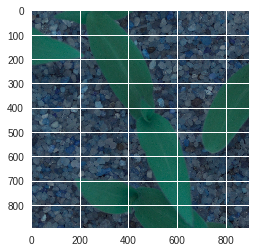

In [29]:
plt.imshow(img)

In [0]:
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp


In [0]:
def segment(img):

  #image_mask = create_mask_for_plant(img)
  image_segmented = segment_plant(img)
  image_sharpen = sharpen_image(image_segmented)
  return image_sharpen

In [0]:
for indx, image in enumerate(images):
  try:
     images[indx] = segment(image)
      
  except:
    print(indx)
    continue

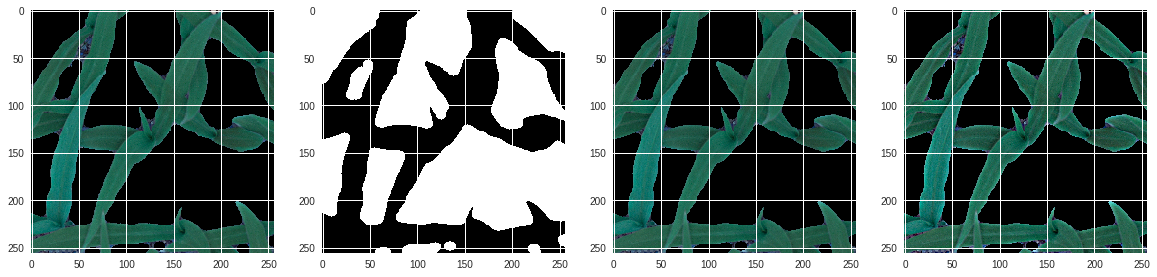

In [33]:
image = images[classes == "Maize"][40]

image_mask = create_mask_for_plant(image)
image_segmented = segment_plant(image)
image_sharpen = sharpen_image(image_segmented)

fig, axs = plt.subplots(1, 4, figsize=(20, 20))
axs[0].imshow(image)
axs[1].imshow(image_mask)
axs[2].imshow(image_segmented)
axs[3].imshow(image_sharpen)

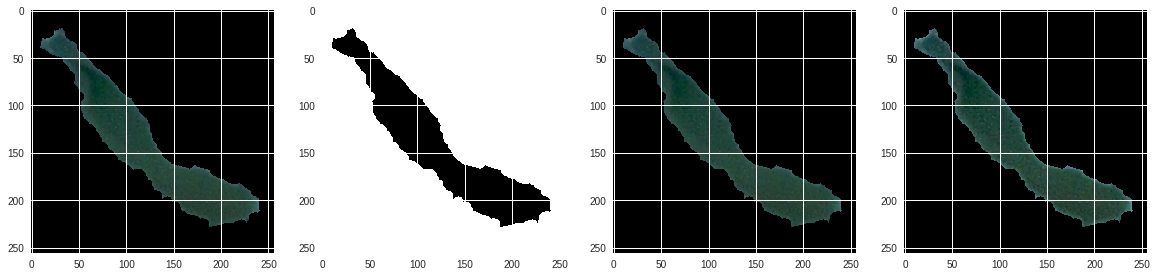

In [42]:
image = images[classes == "Common wheat"][38]

image_mask = create_mask_for_plant(image)
image_segmented = segment_plant(image)
image_sharpen = sharpen_image(image_segmented)

fig, axs = plt.subplots(1, 4, figsize=(20, 20))
axs[0].imshow(image)
axs[1].imshow(image_mask)
axs[2].imshow(image_segmented)
axs[3].imshow(image_sharpen)

In [43]:
images.shape

(729, 256, 256, 3)

In [0]:
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y = enc.fit_transform(classes)

In [47]:
y[0]

array([1, 0, 0])

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, y, test_size=0.3, random_state=50)

In [49]:
X_train.shape

(510, 256, 256, 3)

In [0]:
random_seed = 2
from sklearn.model_selection import train_test_split
X_test, X_val, y_test, Y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state=random_seed)

In [51]:
print(X_test.shape)
print(X_val.shape)

(109, 256, 256, 3)
(110, 256, 256, 3)


In [55]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalMaxPooling2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

# Set the CNN model 

batch_size = None

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', batch_input_shape = (batch_size,256, 256, 3)))


model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.4))



model.add(GlobalMaxPooling2D())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(3, activation = "softmax"))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 256, 256, 32)      2432      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 256, 256, 32)      25632     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 64)        0         
__________

In [0]:
opt = Adam(lr=0.001)

optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])

In [57]:
# We are using colab for time being resaon  :D 
# Using epochs = 50 and I waited until it reach a acceptable accuracy for me then I stopped the training at this point.
model.fit(X_train, y_train, epochs = 50, validation_data = (X_val,Y_val),batch_size = batch_size)

Train on 510 samples, validate on 110 samples
Epoch 1/50
510/510 [==============================] - 19s 37ms/step - loss: 8.5701 - acc: 0.3412 - val_loss: 1.1125 - val_acc: 0.2818
Epoch 2/50
510/510 [==============================] - 7s 14ms/step - loss: 1.1965 - acc: 0.3529 - val_loss: 1.1325 - val_acc: 0.2818
Epoch 3/50
510/510 [==============================] - 7s 14ms/step - loss: 1.0951 - acc: 0.3804 - val_loss: 1.0956 - val_acc: 0.3091
Epoch 4/50
510/510 [==============================] - 7s 14ms/step - loss: 1.0833 - acc: 0.3843 - val_loss: 1.0828 - val_acc: 0.3273
Epoch 5/50
510/510 [==============================] - 7s 14ms/step - loss: 1.0887 - acc: 0.4098 - val_loss: 1.0466 - val_acc: 0.4364
Epoch 6/50
510/510 [==============================] - 7s 14ms/step - loss: 1.0411 - acc: 0.4608 - val_loss: 0.9713 - val_acc: 0.6000
Epoch 7/50
510/510 [==============================] - 7s 14ms/step - loss: 1.0133 - acc: 0.6059 - val_loss: 0.8826 - val_acc: 0.5636
Epoch 8/50
510/510 [==

In [58]:
score = model.evaluate(X_test, y_test, verbose=0, batch_size = 38)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.4468266691910018
Test accuracy: 0.8990825715414975


In [59]:
X_test.shape

(109, 256, 256, 3)

In [0]:
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [0]:
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 50
batch_size = 38

In [65]:
X_train, X_test, y_train, y_test
history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/50
 - 12s - loss: 0.2753 - acc: 0.9089 - val_loss: 0.4637 - val_acc: 0.8818
Epoch 2/50
 - 9s - loss: 0.3372 - acc: 0.8791 - val_loss: 0.5243 - val_acc: 0.8455
Epoch 3/50
 - 9s - loss: 0.2274 - acc: 0.9188 - val_loss: 0.4492 - val_acc: 0.8818
Epoch 4/50
 - 9s - loss: 0.2894 - acc: 0.8933 - val_loss: 0.5410 - val_acc: 0.8727

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/50
 - 9s - loss: 0.1500 - acc: 0.9345 - val_loss: 0.3911 - val_acc: 0.8909
Epoch 6/50
 - 9s - loss: 0.1450 - acc: 0.9426 - val_loss: 0.3934 - val_acc: 0.9000
Epoch 7/50
 - 9s - loss: 0.1269 - acc: 0.9553 - val_loss: 0.5791 - val_acc: 0.8545
Epoch 8/50
 - 9s - loss: 0.1290 - acc: 0.9533 - val_loss: 0.4214 - val_acc: 0.8818
Epoch 9/50
 - 9s - loss: 0.0870 - acc: 0.9649 - val_loss: 0.5210 - val_acc: 0.8818

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 10/50
 - 9s - loss: 0.1279 - acc: 0.9542 - val_loss: 0.4644 - val_acc: 0.8909
Epoch 

In [66]:
score = model.evaluate(X_test, y_test, verbose=0, batch_size = None)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.39500257224186297
Test accuracy: 0.926605504587156


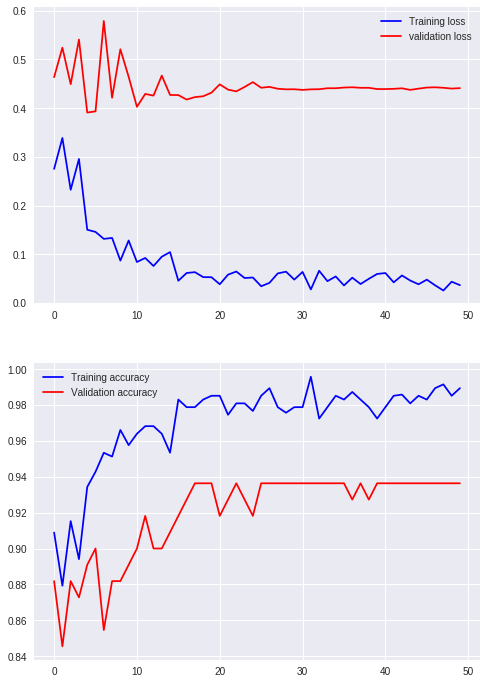

In [70]:
fig, ax = plt.subplots(2,1 , figsize=(8,12))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

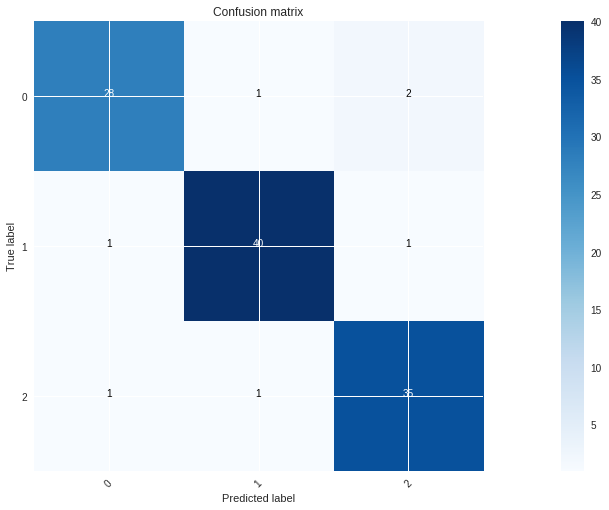

In [73]:
from sklearn.metrics import confusion_matrix
import itertools
plt.subplots(figsize=(22,7)) #set the size of the plot 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3)) 

In [0]:
newpath = '/content/Seedling_sample'

In [0]:
model_json = model.to_json()
with open(os.path.join(os.path.abspath(newpath), 'model.json'), 'w') as json_file:
        json_file.write(model_json)

In [0]:
Predicted_classes = model.predict_classes(X_test)

In [79]:
Predicted_classes

array([0, 0, 0, 0, 2, 2, 0, 0, 1, 0, 0, 2, 0, 1, 2, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 2, 2, 0, 1, 0, 2, 2, 0, 1, 2, 0, 1, 1, 1, 1, 2, 1, 0, 1, 2,
       2, 0, 1, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 1, 0,
       1, 1, 1, 0, 2, 2, 1, 1, 0, 2, 0, 1, 2, 0, 1, 2, 2, 1, 1, 0, 1, 0,
       2, 2, 0, 2, 0, 2, 2, 2, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2])

In [0]:
preds = X_test[Predicted_classes == np.argmax(y_test)]

In [82]:
set(Predicted_classes)

{0, 1, 2}

In [0]:
i = 1

Predicted class: Cleavers
Actual class: Cleavers


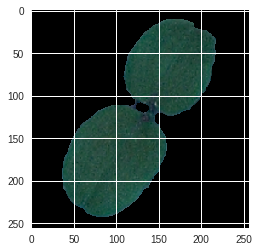

In [85]:
pred = model.predict_classes(np.array([preds[i]]))[0]
act = np.argmax(y_test[i])
print("Predicted class: {}".format(enc.classes_[pred]))
print("Actual class: {}".format(enc.classes_[act]))

plt.imshow(preds[i])

Predicted class: Cleavers
Actual class: Cleavers


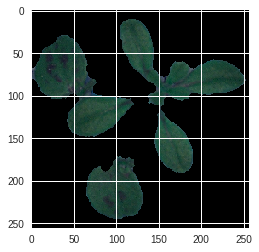

In [86]:
i=2
pred = model.predict_classes(np.array([preds[i]]))[0]
act = np.argmax(y_test[i])
print("Predicted class: {}".format(enc.classes_[pred]))
print("Actual class: {}".format(enc.classes_[act]))

plt.imshow(preds[i])

Predicted class: ['Cleavers']
Actual class: Cleavers


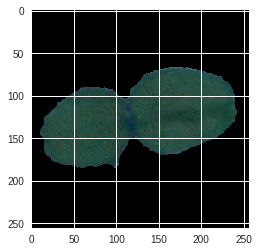

In [105]:
i=10
pred = model.predict_classes(np.array([preds[i]]))
act = np.argmax(y_test[i])
print("Predicted class: {}".format(enc.classes_[pred]))
print("Actual class: {}".format(enc.classes_[act]))

plt.imshow(preds[i])